## Task 1: Project Overview and Import Libraries

In [119]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [120]:
df = pd.read_csv("S&P_500_Index_Data.csv", parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [121]:
df.shape

(8192, 2)

In [122]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["date"], 
                         y=df["close"],
                         mode="lines", 
                         name="close"))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [123]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [124]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[["close"]])

train["close"] = scaler.transform(train[["close"]])
test["close"] = scaler.transform(test[["close"]])

## Task 4: Create Training and Test Splits

In [125]:
def create_dataset(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x.iloc[i:(i + time_steps)].values
        xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(xs), np.array(ys)

In [126]:
time_steps=30

x_train, y_train = create_sequances(train[['close']], 
                                    train.close, 
                                    time_steps)

x_test, y_test = create_sequances(test[['close']], 
                                  test.close, 
                                  time_steps)

In [127]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6523, 30, 1) (6523,)
(1609, 30, 1) (1609,)


## Task 5: Build an LSTM Autoencoder

In [128]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [130]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                      patience=3, 
                                      mode="min")
history = model.fit(x_train, 
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks = [es],
                    shuffle=False)

Epoch 1/100
184/184 [==============================] - 17s 94ms/step - loss: 0.1652 - val_loss: 0.1742
Epoch 2/100
184/184 [==============================] - 25s 137ms/step - loss: 0.1136 - val_loss: 0.0572
Epoch 3/100
184/184 [==============================] - 26s 140ms/step - loss: 0.0901 - val_loss: 0.0524
Epoch 4/100
184/184 [==============================] - 22s 117ms/step - loss: 0.0808 - val_loss: 0.0530
Epoch 5/100
184/184 [==============================] - 17s 92ms/step - loss: 0.0762 - val_loss: 0.0427
Epoch 6/100
184/184 [==============================] - 16s 88ms/step - loss: 0.0773 - val_loss: 0.0484
Epoch 7/100
184/184 [==============================] - 16s 88ms/step - loss: 0.0754 - val_loss: 0.0785
Epoch 8/100
184/184 [==============================] - 21s 116ms/step - loss: 0.0766 - val_loss: 0.0382
Epoch 9/100
184/184 [==============================] - 24s 129ms/step - loss: 0.0714 - val_loss: 0.0282
Epoch 10/100
184/184 [==============================] - 16s 88ms/ste

## Task 7: Plot Metrics and Evaluate the Model

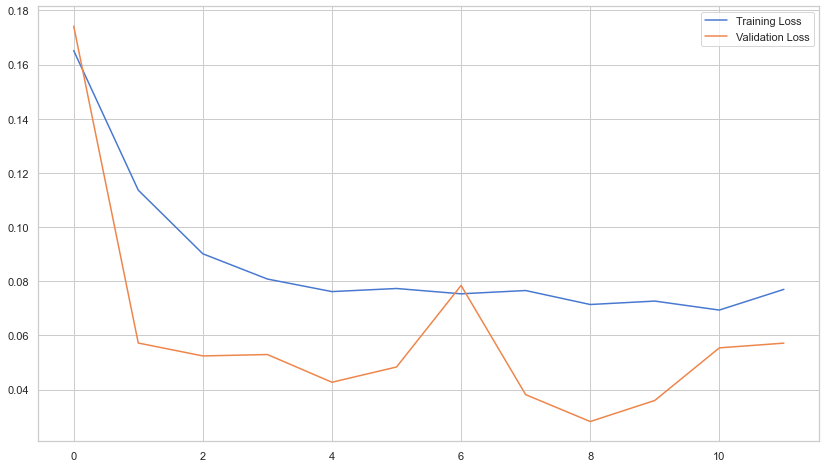

In [131]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [132]:
x_train_prd = model.predict(x_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_prd-x_train), axis=1), columns=["Error"])

In [133]:
model.evaluate(x_test, y_test)

51/51 [==============================] - 2s 31ms/step - loss: 0.3680


0.3679693043231964

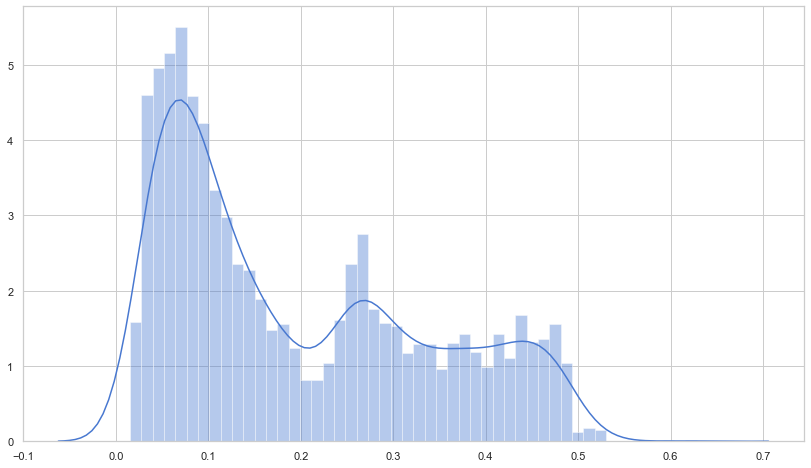

In [134]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [135]:
threshold = 0.65

In [136]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)

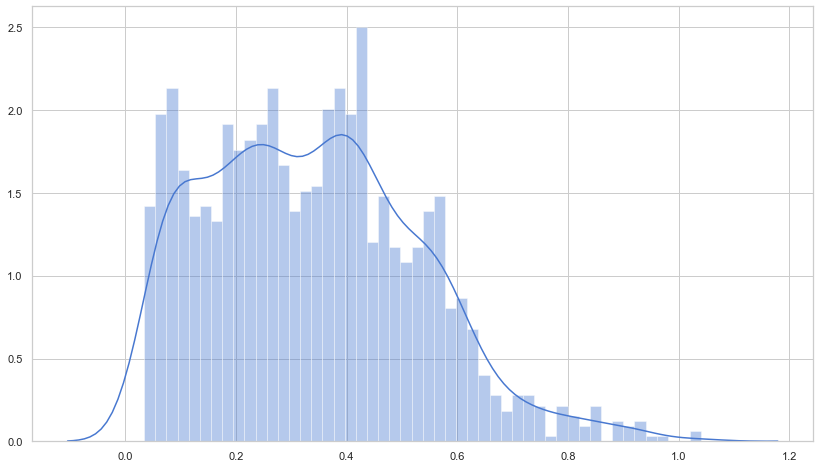

In [137]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [138]:
test_score_df = pd.DataFrame(test[time_steps:])

test_score_df["loss"] = test_mae_loss 
test_score_df["threshold"] = threshold
test_score_df["anomaly"] = test_score_df["loss"] > test_score_df["threshold"]
test_score_df["close"] = test[time_steps:]["close"]

In [139]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.056108,0.65,False
6584,2012-02-09,1.221625,0.056164,0.65,False
6585,2012-02-10,1.199313,0.056041,0.65,False
6586,2012-02-13,1.221194,0.056124,0.65,False
6587,2012-02-14,1.218150,0.054679,0.65,False


In [140]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.736904,0.65,True
8188,2018-06-26,4.507583,0.782381,0.65,True
8189,2018-06-27,4.451431,0.792569,0.65,True
8190,2018-06-28,4.491406,0.822123,0.65,True
8191,2018-06-29,4.496343,0.811552,0.65,True


In [142]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df["date"], 
                         y=test_score_df["loss"],
                         mode="lines", 
                         name="Test Loss"))

fig.add_trace(go.Scatter(x=test_score_df["date"], 
                         y=test_score_df["threshold"],
                         mode="lines", 
                         name="Threshold"))
fig.update_layout(showlegend=True)
fig.show()

In [144]:
anomallis = test_score_df[test_score_df["anomaly"] == True]
anomallis.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.725143,0.65,True
7475,2015-08-26,2.632149,0.792587,0.65,True
7476,2015-08-27,2.745147,0.701333,0.65,True
7976,2017-08-22,3.859192,0.652244,0.65,True
8089,2018-02-02,4.601217,0.656237,0.65,True


In [146]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df["date"], 
                         y=scaler.inverse_transform(test_score_df["close"]),
                         mode="lines", 
                         name="Close Price"))

fig.add_trace(go.Scatter(x=anomallis["date"], 
                         y=scaler.inverse_transform(anomallis["close"]),
                         mode="markers", 
                         name="Anomaly"))
fig.update_layout(showlegend=True)
fig.show()